# <a id='basic'> Tweet Sentiment Extraction<a/>
### Extract support phrases for sentiment labels

# <a id='basic'> Import Library</a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import string
import re
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from tqdm import tqdm,trange,tqdm_notebook # predict the remaining time and to skip unnecessary iteration displays, which allows for a negligible overhead in most cases.
#from tqdm import tqdm.notebook.tqdm

In [ ]:
train = pd.read_csv('../input/tweet-sentiment-extraction/train.csv')
test = pd.read_csv('../input/tweet-sentiment-extraction/test.csv')

# <a id='basic'> Exploratory data analysis <a/>

In [ ]:
train.head()

In [ ]:
test.head()

In [ ]:
train.info()

In [ ]:
train = train.dropna() # to remove missing values

In [ ]:
print('The number of training data points are: ',train.shape[0])

In [ ]:
train.shape

In [ ]:
print('The number of testing data points are: ',test.shape[0])

### In this competetion our agenda is need to pick out the part of the tweet (word or phrase) that reflects the sentiment.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
sns.countplot(train['sentiment'])

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(test['sentiment'])

In [ ]:
ax = (pd.Series(train['sentiment']).value_counts(normalize=True, sort=False)*100).plot.bar()
ax.set(ylabel="Percent")
plt.show()

In [ ]:
temp = train.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='Purples')

In [ ]:
ax = (pd.Series(test['sentiment']).value_counts(normalize=True, sort=False)*100).plot.bar()
ax.set(ylabel="Percent")
plt.show()

## Visualize the words and Phrase through WordCloud, I am sure It will be Fun

In [ ]:
def plotWordClouds(df_text,sentiment):
    text = " ".join(str(tmptext) for tmptext in df_text)
    text = text.lower()
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=300,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(text)
  
    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title('WordCloud - ' + sentiment)
    plt.show()     

In [ ]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

In [ ]:
subtext = train[train['sentiment']=='positive']['selected_text']
plotWordClouds(subtext,'positive')

In [ ]:
subtext = train[train['sentiment']=='neutral']['selected_text']
plotWordClouds(subtext,'neutral')

In [ ]:
subtext = train[train['sentiment']=='negative']['selected_text']
plotWordClouds(subtext,'negative')

So from the Above Wordcloud we understand the basic sense about positive negative and Neutral words.

In [ ]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

train['text'] = train['text'].apply(lambda x:clean_text(x))
train['selected_text'] = train['selected_text'].apply(lambda x:clean_text(x))

In [ ]:
train.head(5)

### Removing Stopwords

In [ ]:
#def remove_stopword(x):
#    return [y for y in x if y not in stopwords.words('english')]
#train['temp_list'] = train['temp_list'].apply(lambda x:remove_stopword(x))

## Most Common Words Used

In [ ]:
from collections import Counter
train['temp_list'] = train['selected_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(30))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

In [ ]:
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Selected Text', orientation='h', 
             width=900, height=800,color='Common_words')
fig.show()

# <a id = 'basic'>Evaluation Metric<a/>

The metric in this competition is the word-level Jaccard score. A good description of Jaccard similarity for strings is here.
A Python implementation based on the links above, and matched with the output of the C# implementation on the back end, is provided below.

In [ ]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

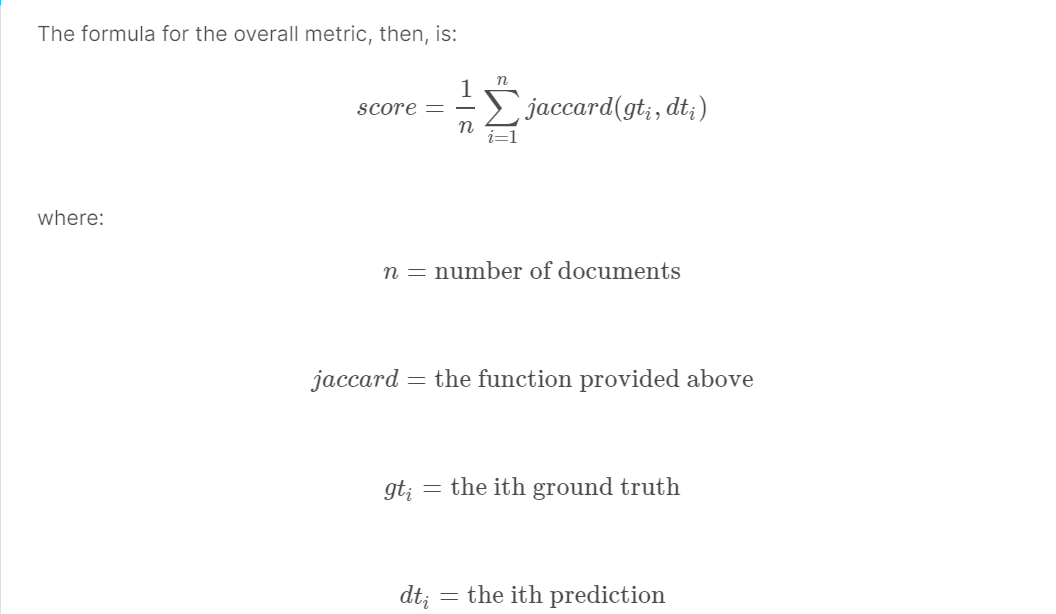

## Understanding Jaccard similarity with two simple sentence

In [ ]:
import nltk 
a = set('I love my girlfriend so much'.lower().split())
b = set('My girlfriend love me always'.lower().split())
 
print ("Jaccard similarity of above two sentences is",1-nltk.jaccard_distance(a, b))

SO we understand the similarity, now I hope we have understand in which way we have to pass so that we can evaluate this problem.

#### I know understanding this formulae is little difficult, no worry, you will get it gradually :-)


## Here we will use Pytorch for further process.
PyTorch is an open-source deep learning framework which is used for implementing network architectures like RNN, CNN, LSTM, etc and other high-level algorithms.

In [ ]:
pip install utils


In [ ]:
import os
import torch
import pandas as pd
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.optim import lr_scheduler

from sklearn import model_selection
from sklearn import metrics
import transformers
import tokenizers
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from tqdm.autonotebook import tqdm
import utils

Now the Bert will begin it's magic to get into the closed results of this competetion. I am using the Bert model from Abhishek Thakur's Bag.
@Lorenzo Ampil's Notebook helped me to understand the deep learning part.

# Utils Script

In [ ]:
import numpy as np
import torch


class AverageMeter:
    """
    Computes and stores the average and current value
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


class EarlyStopping:
    def __init__(self, patience=7, mode="max", delta=0.001):
        self.patience = patience
        self.counter = 0
        self.mode = mode
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        if self.mode == "min":
            self.val_score = np.Inf
        else:
            self.val_score = -np.Inf

    def __call__(self, epoch_score, model, model_path):

        if self.mode == "min":
            score = -1.0 * epoch_score
        else:
            score = np.copy(epoch_score)

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(epoch_score, model, model_path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print('EarlyStopping counter: {} out of {}'.format(self.counter, self.patience))
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(epoch_score, model, model_path)
            self.counter = 0

    def save_checkpoint(self, epoch_score, model, model_path):
        if epoch_score not in [-np.inf, np.inf, -np.nan, np.nan]:
            print('Validation score improved ({} --> {}). Saving model!'.format(self.val_score, epoch_score))
            torch.save(model.state_dict(), model_path)
        self.val_score = epoch_score


def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [ ]:
import utils

In [ ]:
class config:
    MAX_LEN = 128
    TRAIN_BATCH_SIZE = 64
    VALID_BATCH_SIZE = 16
    EPOCHS = 5
    BERT_PATH = "../input/bert-base-uncased/"
    MODEL_PATH = "model.bin"
    TRAINING_FILE = "../input/tweet-train-folds/train_folds.csv"
    TOKENIZER = tokenizers.BertWordPieceTokenizer(
        f"{BERT_PATH}/vocab.txt", 
        lowercase=True)

# <a id='basic'> Processing Data <a/>

In [ ]:
def process_data(tweet, selected_text, sentiment, tokenizer, max_len):
    """
    Processes the tweet and outputs the features necessary for model training and inference
    """
    len_st = len(selected_text)
    idx0 = None
    idx1 = None
    # Finds the start and end indices of the span
    for ind in (i for i, e in enumerate(tweet) if e == selected_text[0]):
        if tweet[ind: ind+len_st] == selected_text:
            idx0 = ind
            idx1 = ind + len_st - 1
            break

    # Assign a positive label for the characters within the selected span (based on the start and end indices)
    char_targets = [0] * len(tweet)
    if idx0 != None and idx1 != None:
        for ct in range(idx0, idx1 + 1):
            char_targets[ct] = 1
    
    # Encode the tweet using the set tokenizer (converted to ids corresponding to word pieces)
    tok_tweet = tokenizer.encode(tweet)
    # Save the ids and offsets (character level indices)
    # Ommit the first and last tokens, which should be the [CLS] and [SEP] tokens
    input_ids_orig = tok_tweet.ids[1:-1]
    tweet_offsets = tok_tweet.offsets[1:-1]
    
    # A token is considered "positive" when it has at least one character with a positive label
    # The indices of the "positive" tokens are stored in `target_idx`.
    target_idx = []
    for j, (offset1, offset2) in enumerate(tweet_offsets):
        if sum(char_targets[offset1: offset2]) > 0:
            target_idx.append(j)
    
    # Store the indices of the first and last "positive" tokens
    targets_start = target_idx[0]
    targets_end = target_idx[-1]

    sentiment_id = {
        'positive': 3893,
        'negative': 4997,
        'neutral': 8699
    }
    
    # Prepend the beginning of the tweet with the [CLS] token (101), and tweet sentiment, represented by the `sentiment_id`
    # The [SEP] token (102) is both prepended and appended to the tweet
    # You can find the indices in the vocab file: https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt
    input_ids = [101] + [sentiment_id[sentiment]] + [102] + input_ids_orig + [102]
    token_type_ids = [0, 0, 0] + [1] * (len(input_ids_orig) + 1)
    mask = [1] * len(token_type_ids)
    tweet_offsets = [(0, 0)] * 3 + tweet_offsets + [(0, 0)]
    targets_start += 3
    targets_end += 3

    # Pad sequence if its length < `max_len`
    padding_length = max_len - len(input_ids)
    if padding_length > 0:
        input_ids = input_ids + ([0] * padding_length)
        mask = mask + ([0] * padding_length)
        token_type_ids = token_type_ids + ([0] * padding_length)
        tweet_offsets = tweet_offsets + ([(0, 0)] * padding_length)
    
    # Return processed tweet as a dictionary
    return {
        'ids': input_ids,
        'mask': mask,
        'token_type_ids': token_type_ids,
        'targets_start': targets_start,
        'targets_end': targets_end,
        'orig_tweet': tweet,
        'orig_selected': selected_text,
        'sentiment': sentiment,
        'offsets': tweet_offsets
    }

In [ ]:
class TweetDataset:
    """
    Dataset which stores the tweets and returns them as processed features
    """
    def __init__(self, tweet, sentiment, selected_text):
        self.tweet = tweet
        self.sentiment = sentiment
        self.selected_text = selected_text
        self.tokenizer = config.TOKENIZER
        self.max_len = config.MAX_LEN
    
    def __len__(self):
        return len(self.tweet)

    def __getitem__(self, item):
        data = process_data(
            self.tweet[item], 
            self.selected_text[item], 
            self.sentiment[item],
            self.tokenizer,
            self.max_len
        )

        # Return the processed data where the lists are converted to `torch.tensor`s
        return {
            'ids': torch.tensor(data["ids"], dtype=torch.long),
            'mask': torch.tensor(data["mask"], dtype=torch.long),
            'token_type_ids': torch.tensor(data["token_type_ids"], dtype=torch.long),
            'targets_start': torch.tensor(data["targets_start"], dtype=torch.long),
            'targets_end': torch.tensor(data["targets_end"], dtype=torch.long),
            'orig_tweet': data["orig_tweet"],
            'orig_selected': data["orig_selected"],
            'sentiment': data["sentiment"],
            'offsets': torch.tensor(data["offsets"], dtype=torch.long)
        }

# <a id='basic'> Model <a/>

In [ ]:
class TweetModel(transformers.BertPreTrainedModel):
    """
    Model class that combines a pretrained bert model with a linear later
    """
    def __init__(self, conf):
        super(TweetModel, self).__init__(conf)
        # Load the pretrained BERT model
        self.bert = transformers.BertModel.from_pretrained(config.BERT_PATH, config=conf)
        # Set 10% dropout to be applied to the BERT backbone's output
        self.drop_out = nn.Dropout(0.1)
        # 768 is the dimensionality of bert-base-uncased's hidden representations
        # Multiplied by 2 since the forward pass concatenates the last two hidden representation layers
        # The output will have two dimensions ("start_logits", and "end_logits")
        self.l0 = nn.Linear(768 * 2, 2)
        torch.nn.init.normal_(self.l0.weight, std=0.02)
    
    def forward(self, ids, mask, token_type_ids):
        # Return the hidden states from the BERT backbone
        _, _, out = self.bert(
            ids,
            attention_mask=mask,
            token_type_ids=token_type_ids
        ) # bert_layers x bs x SL x (768 * 2)

        # Concatenate the last two hidden states
        # This is done since experiments have shown that just getting the last layer
        # gives out vectors that may be too taylored to the original BERT training objectives (MLM + NSP)
        # Sample explanation: https://bert-as-service.readthedocs.io/en/latest/section/faq.html#why-not-the-last-hidden-layer-why-second-to-last
        out = torch.cat((out[-1], out[-2]), dim=-1) # bs x SL x (768 * 2)
        # Apply 10% dropout to the last 2 hidden states
        out = self.drop_out(out) # bs x SL x (768 * 2)
        # The "dropped out" hidden vectors are now fed into the linear layer to output two scores
        logits = self.l0(out) # bs x SL x 2

        # Splits the tensor into start_logits and end_logits
        # (bs x 2) -> (bs x SL x 1), (bs x SL x 1)
        start_logits, end_logits = logits.split(1, dim=-1)

        start_logits = start_logits.squeeze(-1) # (bs x SL)
        end_logits = end_logits.squeeze(-1) # (bs x SL)

        return start_logits, end_logits

### Defining loss function is necessary in the aspect of machine learning !

**What is Loss Function ?**
it's a method of evaluating how well your algorithm models your dataset. If your predictions are totally off, your loss function will output a higher number. If they're pretty good, it'll output a lower number.

Do you Understand ?
Yes I am sure you know it !

In [ ]:
def loss_fn(start_logits, end_logits, start_positions, end_positions):
    """
    Return the sum of the cross entropy losses for both the start and end logits
    """
    loss_fct = nn.CrossEntropyLoss()
    start_loss = loss_fct(start_logits, start_positions)
    end_loss = loss_fct(end_logits, end_positions)
    total_loss = (start_loss + end_loss)
    return total_loss

# <a id='basic'> Training Function <a/>

In [ ]:
def train_fn(data_loader, model, optimizer, device, scheduler=None):
    """
    Trains the bert model on the twitter data
    """
    # Set model to training mode (dropout + sampled batchnorm is activated)
    model.train()
    losses = utils.AverageMeter()
    jaccards = utils.AverageMeter()

    # Set tqdm to add loading screen and set the length
    tk0 = tqdm(data_loader, total=len(data_loader))
    
    # Train the model on each batch
    for bi, d in enumerate(tk0):

        ids = d["ids"]
        token_type_ids = d["token_type_ids"]
        mask = d["mask"]
        targets_start = d["targets_start"]
        targets_end = d["targets_end"]
        sentiment = d["sentiment"]
        orig_selected = d["orig_selected"]
        orig_tweet = d["orig_tweet"]
        targets_start = d["targets_start"]
        targets_end = d["targets_end"]
        offsets = d["offsets"]

        # Move ids, masks, and targets to gpu while setting as torch.long
        ids = ids.to(device, dtype=torch.long)
        token_type_ids = token_type_ids.to(device, dtype=torch.long)
        mask = mask.to(device, dtype=torch.long)
        targets_start = targets_start.to(device, dtype=torch.long)
        targets_end = targets_end.to(device, dtype=torch.long)

        # Reset gradients
        model.zero_grad()
        # Use ids, masks, and token types as input to the model
        # Predict logits for each of the input tokens for each batch
        outputs_start, outputs_end = model(
            ids=ids,
            mask=mask,
            token_type_ids=token_type_ids,
        ) # (bs x SL), (bs x SL)
        # Calculate batch loss based on CrossEntropy
        loss = loss_fn(outputs_start, outputs_end, targets_start, targets_end)
        # Calculate gradients based on loss
        loss.backward()
        # Adjust weights based on calculated gradients
        optimizer.step()
        # Update scheduler
        scheduler.step()
        
        # Apply softmax to the start and end logits
        # This squeezes each of the logits in a sequence to a value between 0 and 1, while ensuring that they sum to 1
        # This is similar to the characteristics of "probabilities"
        outputs_start = torch.softmax(outputs_start, dim=1).cpu().detach().numpy()
        outputs_end = torch.softmax(outputs_end, dim=1).cpu().detach().numpy()
        
        # Calculate the jaccard score based on the predictions for this batch
        jaccard_scores = []
        for px, tweet in enumerate(orig_tweet):
            selected_tweet = orig_selected[px]
            tweet_sentiment = sentiment[px]
            jaccard_score, _ = calculate_jaccard_score(
                original_tweet=tweet, # Full text of the px'th tweet in the batch
                target_string=selected_tweet, # Span containing the specified sentiment for the px'th tweet in the batch
                sentiment_val=tweet_sentiment, # Sentiment of the px'th tweet in the batch
                idx_start=np.argmax(outputs_start[px, :]), # Predicted start index for the px'th tweet in the batch
                idx_end=np.argmax(outputs_end[px, :]), # Predicted end index for the px'th tweet in the batch
                offsets=offsets[px] # Offsets for each of the tokens for the px'th tweet in the batch
            )
            jaccard_scores.append(jaccard_score)
        # Update the jaccard score and loss
        # For details, refer to `AverageMeter` in https://www.kaggle.com/abhishek/utils
        jaccards.update(np.mean(jaccard_scores), ids.size(0))
        losses.update(loss.item(), ids.size(0))
        # Print the average loss and jaccard score at the end of each batch
        tk0.set_postfix(loss=losses.avg, jaccard=jaccards.avg)

# <a id='basic'> Evaluation Function <a/>

In [ ]:
def calculate_jaccard_score(
    original_tweet, 
    target_string, 
    sentiment_val, 
    idx_start, 
    idx_end, 
    offsets,
    verbose=False):
    """
    Calculate the jaccard score from the predicted span and the actual span for a batch of tweets
    """
    
    # A span's start index has to be greater than or equal to the end index
    # If this doesn't hold, the start index is set to equal the end index (the span is a single token)
    if idx_end < idx_start:
        idx_end = idx_start
    
    # Combine into a string the tokens that belong to the predicted span
    filtered_output  = ""
    for ix in range(idx_start, idx_end + 1):
        filtered_output += original_tweet[offsets[ix][0]: offsets[ix][1]]
        # If the token is not the last token in the tweet, and the ending offset of the current token is less
        # than the beginning offset of the following token, add a space.
        # Basically, add a space when the next token (word piece) corresponds to a new word
        if (ix+1) < len(offsets) and offsets[ix][1] < offsets[ix+1][0]:
            filtered_output += " "

    # Set the predicted output as the original tweet when the tweet's sentiment is "neutral", or the tweet only contains one word
    if sentiment_val == "neutral" or len(original_tweet.split()) < 2:
        filtered_output = original_tweet

    # Calculate the jaccard score between the predicted span, and the actual span
    # The IOU (intersection over union) approach is detailed in the utils module's `jaccard` function:
    # https://www.kaggle.com/abhishek/utils
    jac = utils.jaccard(target_string.strip(), filtered_output.strip())
    return jac, filtered_output


def eval_fn(data_loader, model, device):
    """
    Evaluation function to predict on the test set
    """
    # Set model to evaluation mode
    # I.e., turn off dropout and set batchnorm to use overall mean and variance (from training), rather than batch level mean and variance
    # Reference: https://github.com/pytorch/pytorch/issues/5406
    model.eval()
    losses = utils.AverageMeter()
    jaccards = utils.AverageMeter()
    
    # Turns off gradient calculations (https://datascience.stackexchange.com/questions/32651/what-is-the-use-of-torch-no-grad-in-pytorch)
    with torch.no_grad():
        tk0 = tqdm(data_loader, total=len(data_loader))
        # Make predictions and calculate loss / jaccard score for each batch
        for bi, d in enumerate(tk0):
            ids = d["ids"]
            token_type_ids = d["token_type_ids"]
            mask = d["mask"]
            sentiment = d["sentiment"]
            orig_selected = d["orig_selected"]
            orig_tweet = d["orig_tweet"]
            targets_start = d["targets_start"]
            targets_end = d["targets_end"]
            offsets = d["offsets"].numpy()

            # Move tensors to GPU for faster matrix calculations
            ids = ids.to(device, dtype=torch.long)
            token_type_ids = token_type_ids.to(device, dtype=torch.long)
            mask = mask.to(device, dtype=torch.long)
            targets_start = targets_start.to(device, dtype=torch.long)
            targets_end = targets_end.to(device, dtype=torch.long)

            # Predict logits for start and end indexes
            outputs_start, outputs_end = model(
                ids=ids,
                mask=mask,
                token_type_ids=token_type_ids
            )
            # Calculate loss for the batch
            loss = loss_fn(outputs_start, outputs_end, targets_start, targets_end)
            # Apply softmax to the predicted logits for the start and end indexes
            # This converts the "logits" to "probability-like" scores
            outputs_start = torch.softmax(outputs_start, dim=1).cpu().detach().numpy()
            outputs_end = torch.softmax(outputs_end, dim=1).cpu().detach().numpy()
            # Calculate jaccard scores for each tweet in the batch
            jaccard_scores = []
            for px, tweet in enumerate(orig_tweet):
                selected_tweet = orig_selected[px]
                tweet_sentiment = sentiment[px]
                jaccard_score, _ = calculate_jaccard_score(
                    original_tweet=tweet,
                    target_string=selected_tweet,
                    sentiment_val=tweet_sentiment,
                    idx_start=np.argmax(outputs_start[px, :]),
                    idx_end=np.argmax(outputs_end[px, :]),
                    offsets=offsets[px]
                )
                jaccard_scores.append(jaccard_score)

            # Update running jaccard score and loss
            jaccards.update(np.mean(jaccard_scores), ids.size(0))
            losses.update(loss.item(), ids.size(0))
            # Print the running average loss and jaccard score
            tk0.set_postfix(loss=losses.avg, jaccard=jaccards.avg)
    
    print(f"Jaccard = {jaccards.avg}")
    return jaccards.avg

# <a id='basic'>Training <a/>

In [ ]:
def run(fold):
    """
    Train model for a speciied fold
    """
    # Read training csv
    dfx = pd.read_csv(config.TRAINING_FILE)

    # Set train validation set split
    df_train = dfx[dfx.kfold != fold].reset_index(drop=True)
    df_valid = dfx[dfx.kfold == fold].reset_index(drop=True)
    
    # Instantiate TweetDataset with training data
    train_dataset = TweetDataset(
        tweet=df_train.text.values,
        sentiment=df_train.sentiment.values,
        selected_text=df_train.selected_text.values
    )

    # Instantiate DataLoader with `train_dataset`
    # This is a generator that yields the dataset in batches
    train_data_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=config.TRAIN_BATCH_SIZE,
        num_workers=4
    )

    # Instantiate TweetDataset with validation data
    valid_dataset = TweetDataset(
        tweet=df_valid.text.values,
        sentiment=df_valid.sentiment.values,
        selected_text=df_valid.selected_text.values
    )

    # Instantiate DataLoader with `valid_dataset`
    valid_data_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=config.VALID_BATCH_SIZE,
        num_workers=2
    )

    # Set device as `cuda` (GPU)
    device = torch.device("cuda")
    # Load pretrained BERT (bert-base-uncased)
    model_config = transformers.BertConfig.from_pretrained(config.BERT_PATH)
    # Output hidden states
    # This is important to set since we want to concatenate the hidden states from the last 2 BERT layers
    model_config.output_hidden_states = True
    # Instantiate our model with `model_config`
    model = TweetModel(conf=model_config)
    # Move the model to the GPU
    model.to(device)

    # Calculate the number of training steps
    num_train_steps = int(len(df_train) / config.TRAIN_BATCH_SIZE * config.EPOCHS)
    # Get the list of named parameters
    param_optimizer = list(model.named_parameters())
    # Specify parameters where weight decay shouldn't be applied
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    # Define two sets of parameters: those with weight decay, and those without
    optimizer_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
    ]
    # Instantiate AdamW optimizer with our two sets of parameters, and a learning rate of 3e-5
    optimizer = AdamW(optimizer_parameters, lr=3e-5)
    # Create a scheduler to set the learning rate at each training step
    # "Create a schedule with a learning rate that decreases linearly after linearly increasing during a warmup period." (https://pytorch.org/docs/stable/optim.html)
    # Since num_warmup_steps = 0, the learning rate starts at 3e-5, and then linearly decreases at each training step
    scheduler = get_linear_schedule_with_warmup(
        optimizer, 
        num_warmup_steps=0, 
        num_training_steps=num_train_steps
    )

    # Apply early stopping with patience of 2
    # This means to stop training new epochs when 2 rounds have passed without any improvement
    es = utils.EarlyStopping(patience=2, mode="max")
    print(f"Training is Starting for fold={fold}")
    
    # I'm training only for 3 epochs even though I specified 5!!!
    for epoch in range(3):
        train_fn(train_data_loader, model, optimizer, device, scheduler=scheduler)
        jaccard = eval_fn(valid_data_loader, model, device)
        print(f"Jaccard Score = {jaccard}")
        es(jaccard, model, model_path=f"model_{fold}.bin")
        if es.early_stop:
            print("Early stopping")
            break

In [ ]:
run(fold=0)

In [ ]:
run(fold=1)

In [ ]:
run(fold=3)

In [ ]:
run(fold=4)

In [ ]:
df_test = test

In [ ]:
df_test.head()

In [ ]:
df_test.loc[:, "selected_text"] = df_test.text.values

In [ ]:
device = torch.device("cuda")
model_config = transformers.BertConfig.from_pretrained(config.BERT_PATH)
model_config.output_hidden_states = True

In [ ]:
# Load each of the five trained models and move to GPU
model1 = TweetModel(conf=model_config)
model1.to(device)
model1.load_state_dict(torch.load("model_0.bin"))
model1.eval()

model2 = TweetModel(conf=model_config)
model2.to(device)
model2.load_state_dict(torch.load("model_1.bin"))
model2.eval()

model3 = TweetModel(conf=model_config)
model3.to(device)
model3.load_state_dict(torch.load("model_2.bin"))
model3.eval()

model4 = TweetModel(conf=model_config)
model4.to(device)
model4.load_state_dict(torch.load("model_3.bin"))
model4.eval()

model5 = TweetModel(conf=model_config)
model5.to(device)
model5.load_state_dict(torch.load("model_4.bin"))
model5.eval()

In [ ]:
final_output = []

# Instantiate TweetDataset with the test data
test_dataset = TweetDataset(
        tweet=df_test.text.values,
        sentiment=df_test.sentiment.values,
        selected_text=df_test.selected_text.values
)

# Instantiate DataLoader with `test_dataset`
data_loader = torch.utils.data.DataLoader(
    test_dataset,
    shuffle=False,
    batch_size=config.VALID_BATCH_SIZE,
    num_workers=1
)

# Turn of gradient calculations
with torch.no_grad():
    tk0 = tqdm(data_loader, total=len(data_loader))
    # Predict the span containing the sentiment for each batch
    for bi, d in enumerate(tk0):
        ids = d["ids"]
        token_type_ids = d["token_type_ids"]
        mask = d["mask"]
        sentiment = d["sentiment"]
        orig_selected = d["orig_selected"]
        orig_tweet = d["orig_tweet"]
        targets_start = d["targets_start"]
        targets_end = d["targets_end"]
        offsets = d["offsets"].numpy()

        ids = ids.to(device, dtype=torch.long)
        token_type_ids = token_type_ids.to(device, dtype=torch.long)
        mask = mask.to(device, dtype=torch.long)
        targets_start = targets_start.to(device, dtype=torch.long)
        targets_end = targets_end.to(device, dtype=torch.long)

        # Predict start and end logits for each of the five models
        outputs_start1, outputs_end1 = model1(
            ids=ids,
            mask=mask,
            token_type_ids=token_type_ids
        )
        
        outputs_start2, outputs_end2 = model2(
            ids=ids,
            mask=mask,
            token_type_ids=token_type_ids
        )
        
        outputs_start3, outputs_end3 = model3(
            ids=ids,
            mask=mask,
            token_type_ids=token_type_ids
        )
        
        outputs_start4, outputs_end4 = model4(
            ids=ids,
            mask=mask,
            token_type_ids=token_type_ids
        )
        
        outputs_start5, outputs_end5 = model5(
            ids=ids,
            mask=mask,
            token_type_ids=token_type_ids
        )
        
        # Get the average start and end logits across the five models and use these as predictions
        # This is a form of "ensembling"
        outputs_start = (
            outputs_start1 
            + outputs_start2 
            + outputs_start3 
            + outputs_start4 
            + outputs_start5
        ) / 5
        outputs_end = (
            outputs_end1 
            + outputs_end2 
            + outputs_end3 
            + outputs_end4 
            + outputs_end5
        ) / 5
        
        # Apply softmax to the predicted start and end logits
        outputs_start = torch.softmax(outputs_start, dim=1).cpu().detach().numpy()
        outputs_end = torch.softmax(outputs_end, dim=1).cpu().detach().numpy()

        # Convert the start and end scores to actual predicted spans (in string form)
        for px, tweet in enumerate(orig_tweet):
            selected_tweet = orig_selected[px]
            tweet_sentiment = sentiment[px]
            _, output_sentence = calculate_jaccard_score(
                original_tweet=tweet,
                target_string=selected_tweet,
                sentiment_val=tweet_sentiment,
                idx_start=np.argmax(outputs_start[px, :]),
                idx_end=np.argmax(outputs_end[px, :]),
                offsets=offsets[px]
            )
            final_output.append(output_sentence)


# WORK IN PROGRESS.................